## Going12 : 직접 만들어보는 OCR

### 실습 목표 
1. Text Recognition 모델을 직접 구현해 봅니다.
2. Text Recognition 모델 학습을 진행해 봅니다.
3. Text Detection 모델과 연결하여 전체 OCR 시스템을 구현합니다.

### 목차

1. Overall sturcture of OCR
2. Dataset for OCR
3. Recognition model
 - Input Image
 - Encode
 - Build CRNN model
 - Train & Inference
4. 프로젝트 : End-to-End OCR

### 12-2 Overall structure of OCR

우리는 이미지 속에서 영문을 Bounding box로 찾고 그 bounding box 내에 어떤 Text가 포함되는지 알 수 있는 시스템인 OCR을 만들어본다. `Text Detection`은 Segmentation 기반의 `CRAFT를 활용한 keras-ocr을 활용`할 예정이다. Recognition 모델은 직접 만든다.

### 12-3 Dataset for OCR

OCR은 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야 하는 번거로움이 있다. 따라서 OCR 데이터를 대량으로 만들려면 큰 비용이 든다. 이런 데이터 문제를 해결하기 위한 방법 중 하나는 컴퓨터로 대량 문자 이미지 데이터를 만들어내는 것이다. `직접 문자 데이터를 생성`하면, 원하는 언어를 원하는 폰트와 원하는 배치 및 크기로 `문자 이미지를 대량으로 만들어낼 수 있다는 장점`이 있다.

https://arxiv.org/pdf/1904.01906.pdf 와 같은 논문들에서 Recognition model의 정량적인 평가를 위해서 `MJSynth`와 `SynthText`라는 데이터셋을 활용한다. Recognition model을 제안하는 다양한 논문들에서도 성능 비교를 위해서 두 데이터를 활용한다.

 1. MJSynth - http://www.robots.ox.ac.uk/~vgg/data/text/
 2. SynthText - http://www.robots.ox.ac.uk/~vgg/data/scenetext/

Recognition model 학습을 위해 `MJSynth`를 사용해본다. Naver Clova의 논문 저자들이 Dropbox를 통해 제공하는 데이터셋이다. 아래 링크의 training 폴더에서 `data_Imdb_release.zip` 내 있는 `MJ` 데이터만 활용할 예정이다.

https://www.dropbox.com/sh/i39abvnefllx2si/AAAbAYRvxzRp3cIE5HzqUw3ra?dl=0

### 데이터 준비

```
$ mkdir -p ~/aiffel/ocr 
$ ln -s ~/data ~/aiffel/ocr/data
```

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


### 12-4 Recognition model 1

Text recognition 모델을 직접 만들어본다. CRNN 구조를 활용해서 만들어 본다.

https://arxiv.org/pdf/1507.05717.pdf

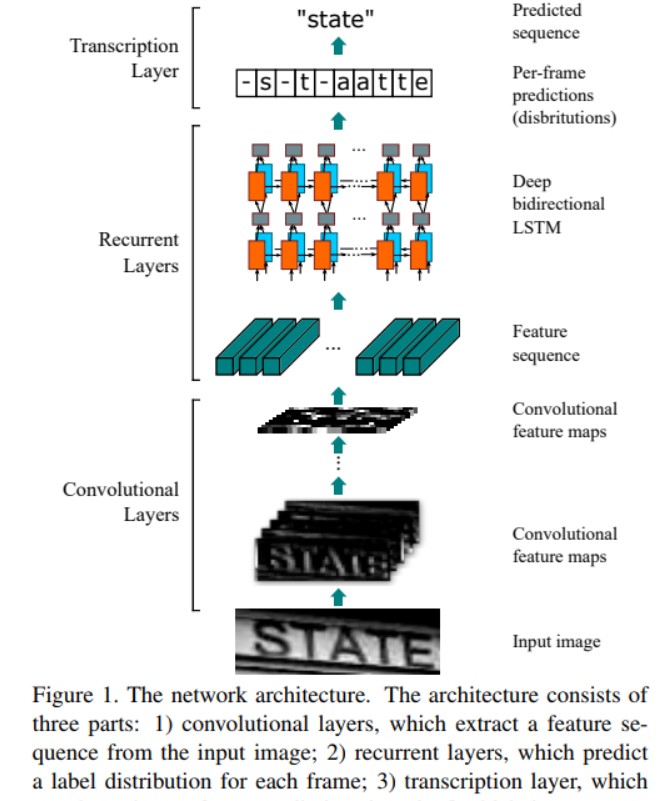


CRNN 구조는 위 그림에서부터 아래부터 올라가는 순서이다. 입력 이미지를 Convolution layer를 통해 feature를 추출하여 추출된 feature를 얻는다. recurrent layer는 추출된 feature의 전체적인 context를 파악하고 다양한 output의 크기에 대응이 가능하다. 끝으로 Transcription layer(Fully connected layer)는 step마다 어떤 character의 확률이 높은지 예측한다. 아래 표를 통해 정확한 구조를 확인해본다.

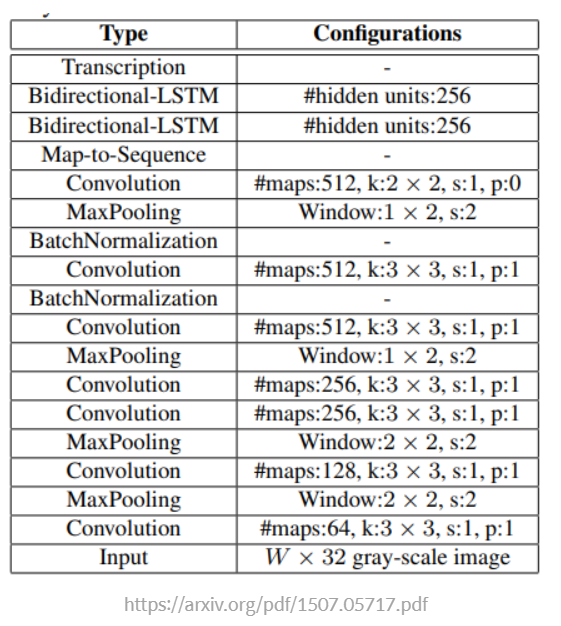

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


먼저 Imdb를 이용한다. LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자이다. 우리가 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있다.

```
$ pip install lmdb
```

필요한 라이브러리 import와 다운로드한 MJ 데이터셋의 위치도 확인한다.

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


### 12-5 Recognition model 2 : Input Image

데이터셋 안에 있는 이미지를 확인해본다. 실제 shape와 이미지나 라벨이 어떻게 달려있는지 확인한다.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


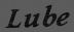

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


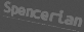

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


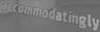

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


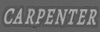

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

lmdb를 활용해 케라스 모델 학습용 `MJSynth` 데이터셋 클래스를 구현하려고 한다. `dataset_path`는 읽어들일 데이터셋의 경로이다. `label_converter`는 아래에서 문자를 미리 정의된 index로 변환해주는 converter로 직접 구현하도록 한다. 이외에 batch_size와 입력 이미지 크기, 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character 등을 입력 받도록 구현되어있다.

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


위 분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 `_get_img_label()` 메소드에 반영되었다. 그리고 `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()`를 통해 가져온 데이터셋을 리턴하게 될 것이다. `_get_img_label()`를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지 맞추게 가공하고 있다.

### 12-6 Recognition model 3 : Encode

Label은 우리가 읽을 수 있는 평문 Text로 이루어져 있다. 하지만 이는 모델을 학습하기 위해 적절한 형태가 아니다. 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해 encode를 해줘야한다. 이를 해줄 수 있는 `LabelConverter` 클래스를 작성해 보자.

 - `__init__()`에서는 입력으로 받은 text를 `self.dict`에 각 character들이 어떤 index에 매핑되는지 저장한다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어진다. 만약 `character='ABCD'`라면 `'A'`의 label은 1, `'B'`의 label은 2가 된다.
 - 공백 문자를 지정한다. 여기서는 `'-'`를 활용하며, label은 0으로 지정한다.
 - `decode()`는 각 index를 다시 character로 변환하고 이어주어 우리가 읽을 수 있는 text로 바꿔준다.

```
입력받은 text를 모델이 학습할 수 있는 label로 만드는 encode() 메소드를 구현해 주세요!
단, 같은 글자가 연속으로 이어지는 경우에는 이어지는 그 사이에 공백 문자의 label을 포함해야 합니다!
```


In [6]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         # [[YOUR CODE]]
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0) # 같은 문자 사이에 공백 문자 
             encoded_label.append(self.label_map[char])

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

# 동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함됨을 볼 수 있다.


Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


### 12-7 Recognition model 4 : Build CRNN model

모델을 만들어본다. Keras에서 제공하는 `K.ctc_batch_cost()`를 활용해 loss를 계산하도록 `ctc_lambda_func`를 아래와 같이 만들어둔다.

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


Keras의 `K.ctc_batch_cost()` 함수에 대해 짚고 넘어간다. CTC Loss를 구현하기 위해 우리가 이 함수에 어떤 인자로 어떤 값을 넘겨야 하는지 명확하게 파악해야 한다.

https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost



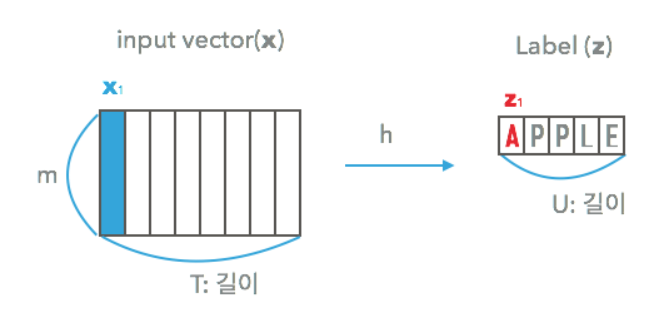

입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 라벨은 `APPLE`이지만 모델이 출력한 결과는 `AAAPPPPLLLLEE`처럼 나올 수 있다. 이런 상황이 이미지에서 텍스트 라벨을 추론해야하는 Text recognition 테스크에 동일하게 적용된다.

```
만약에 모델이 `AAAPPPPLLLLEE`를 출력했다고 한다면 추론 결과는 `APLE`로 결론 짓는다.

그러므로 추론 결과가 `APPLE`이 되게 하려면 이미지 라벨은 `AP-PLE`로 보정해줘야 한다.
그래서 모델이 `AAAPP-PPLLLEE`로 출력한다면 추론 결과는 `APPLE`이 되는 것이다.
이런 이유로 이전 스텝에서 `LabelConverter.encode()` 메소드에 공백문자 처리로직을 포함했던 것이다.
```

`K.ctc_batch_cost(y_true, y_pred, input_length, label_length)`에는 4가지 인자가 존재한다.

 - `y_true`: tensor (samples, max_string_length) containing the truth labels.
 - `y_pred`: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
 - `input_length tensor`: (samples, 1) containing the sequence length for each batch item in y_pred.
 - `label_length tensor`: (samples, 1) containing the sequence length for each batch item in y_true.

(여기서 samples는 배치사이즈를 의미한다.)



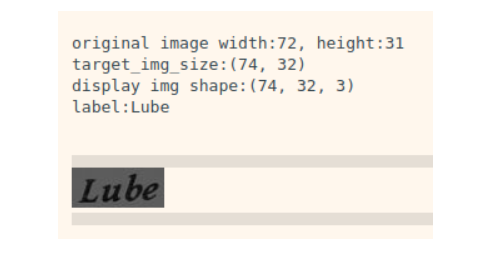

위 그림은 실제 데이터셋 예시이다. 이 케이스를 예로 들었을 때 위 인자들은 다음과 같다.

 - `y_true`: 실제 라벨 `LUBE`. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정  


 - `y_pred`: 우리가 만들 RCNN `모델의 출력 결과`. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정  


 - `input_length tensor`: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 `74`  


 - `label_length tensor`: 라벨의 실제 정답 길이 U로서, 이 경우에는 `4`

`K.ctc_batch_cost()`를 활용해 `image_input`을 입력으로, 마지막 Label을 `output`이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 `build_crnn_model()`을 구현해본다.

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


### 12-8 Recognition model 5 : Train & Inference

앞에서 정의한 `MJDatasetSequence`로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜본다.

In [10]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


실제 학습을 위해선 많은 시간이 소요되니 여기서는 예시로 1 Epoch만 돌려보겠습니다. 뒤에서는 20Epoch 이상 학습된 모델의 가중치를 불러와서 진행할게요.😘

EarlyStopping을 이용하면 훈련이 더 빨리 끝날 수도 있어요!

In [11]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - 97s 151ms/step - loss: 25.5342 - val_loss: 23.4558

Epoch 00001: val_loss improved from inf to 23.45583, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 83s 147ms/step - loss: 15.1074 - val_loss: 10.5735

Epoch 00002: val_loss improved from 23.45583 to 10.57349, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 83s 147ms/step - loss: 7.2492 - val_loss: 6.3973

Epoch 00003: val_loss improved from 10.57349 to 6.39733, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 83s 146ms/step - loss: 5.2026 - val_loss: 5.4259

Epoch 00004: val_loss improved from 6.39733 to 5.42587, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 83s 146ms/step - loss: 4.1328 - val_loss: 4.7234

Epoch 00005: val_loss im

In [11]:
# 학습된 모델을 테스트셋을 통해 확인해본다

# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


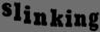

Result: 	 ALEPPO99999999999999999


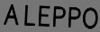

Result: 	 FWANDA999999999999999999


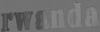

Result: 	 NATHANS99999999999999999


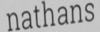

Result: 	 HALLE999999999999999999


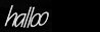

Result: 	 HURLS9999999999999999999


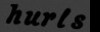

Result: 	 DOWNSIZE9999999999999999


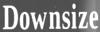

Result: 	 ROBOTIC99999999999999999


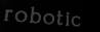

Result: 	 SLOPPY99999999999999999


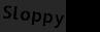

Result: 	 SHERMITE9999999999999999


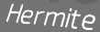

In [12]:
# 학습된 모델의 성능을 눈으로 확인해본다.

from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

## 12-9 프로젝트 : End-to-End OCR

### 라이브러리 버전 확인



In [13]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다. 이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요.


#### 데이터 다운로드 (클라우드 유저용)

step3에서 심볼릭 링크를 사용한 경우, `sample.jpg`는 `~/aiffel/ocr/data` 디렉토리에 있습니다.

In [14]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 단어의 영역을 잘라오도록 해주세요.

In [20]:
from PIL import Image, ImageDraw
import numpy

def detect_text(img_path):
    # TODO
		
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
		
    # 배치의 첫 번째 결과만 가져옵니다.
		
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640,640))
    img_draw = ImageDraw.Draw(img_pil)
    result_img = img_pil
    
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (640,640))
    image = image[tf.newaxis, :, :, :] # 1번 충족
    detection = detector.detect(image.numpy()) 
    ocr_result = detection[0] # 2번 충족
    
    # 3번 충족
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

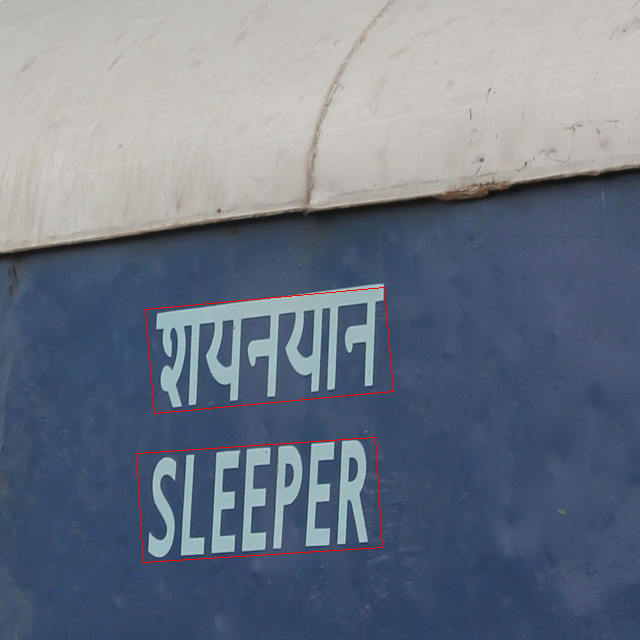

In [21]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

(-0.5, 254.5, 134.5, -0.5)

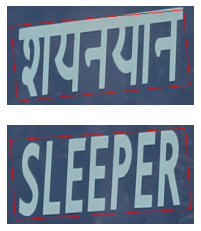

In [61]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.imshow(cropped_img[0])
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(cropped_img[1])
plt.axis('off')

이제 위에서 이미지 내의 단어 이미지를 얻었습니다. 그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보세요!

In [22]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    output = model_pred.predict(np.expand_dims(np.array(pil_img.resize((100, 32), 3)).transpose(1, 0, 2), axis=0))
    result = decode_predict_ctc(output, chars='-'+TARGET_CHARACTERS)[0].replace('-', '')
    print(f'Result: {result}')
    display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))
    

Result: STRUPRUIE999999999999999


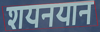

Result: SLEEPERE999999999999999


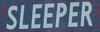

In [23]:
for _img in cropped_img:
    recognize_img(_img)

회고 : aiffelton에 ocr을 적용할 예정이라 좀 집중해서 봤지만 생각보다 너무 어려웠다. 다양한 데이터 전처리와 detection, recognition 모델 구축 등 알아야할 것이 너무나 많아서 힘들었던 노드였다. 하지만 어떤 원리로 keras-ocr이 동작하고 구조를 이루는지 알게되어 뜻깊은 노드였다. 마지막 정확도는 학습이 좀 미흡해서 그런지 높은 정확성을 보이지 못했지만 두번째 단어는 꽤나 정확하게 인식한 것을 볼 수 있었다.